# Deliverable 6.1 — Robust Tube MPC Position Controller (z-axis only)

**Objective:** Design a robust tube MPC controller for the z-subsystem to drive the rocket from z=10m to z=3m while robustly satisfying the ground constraint z≥0 under disturbances w ∈ [-15, 5].

**System:**
- States: x = [vz, z]ᵀ (vertical velocity and position)
- Input: u = Pavg (average throttle, 40-80%)
- Disturbance: w ∈ W = [-15, 5] (vertical force)
- Hard constraint: z ≥ 0 (ground collision avoidance)

## 1. Setup and Imports

In [31]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Path setup
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Imports
from LandMPC.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *

%matplotlib widget

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. System Setup and Controller Initialization

In [32]:
# Rocket parameters
Ts = 1/20  # 20 Hz
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # kg (DO NOT CHANGE)

# Visualization
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

# Initial and reference states
x0 = np.array([0.]*9 + [0., 0., 10.])     # Start at z=10m
x_ref = np.array([0.]*9 + [1., 0., 3.])   # Target z=3m, vx=1m/s

# Trim point (hover at z=3m)
xs, us = rocket.trim(x_ref)

# Linearize
sys_lin = rocket.linearize_sys(xs, us)
A, B = sys_lin.A, sys_lin.B

In [33]:
# Create Tube MPC controller
H = 4 # SHORT horizon for absolute maximum speed
sim_time = 10.0  # Simulation length

mpc = MPCControl_z(A, B, xs, us, Ts, H)

## 3. Visualize Computed Sets

Display the RPI set E, tightened state constraint X̃, terminal set Xf, and tightened input constraint Ũ.

In [34]:
# Extract Terminal sets from controller
Xf = mpc.Xf       

print(f"Terminal Set Xf:")
try:
    Xf.minimize()
    print(f"   Facets: {Xf.A.shape[0]}, Vertices: {Xf.V.shape[0]}")
except:
    print(f"   Facets: {Xf.A.shape[0]}")

Terminal Set Xf:
   Facets: 27


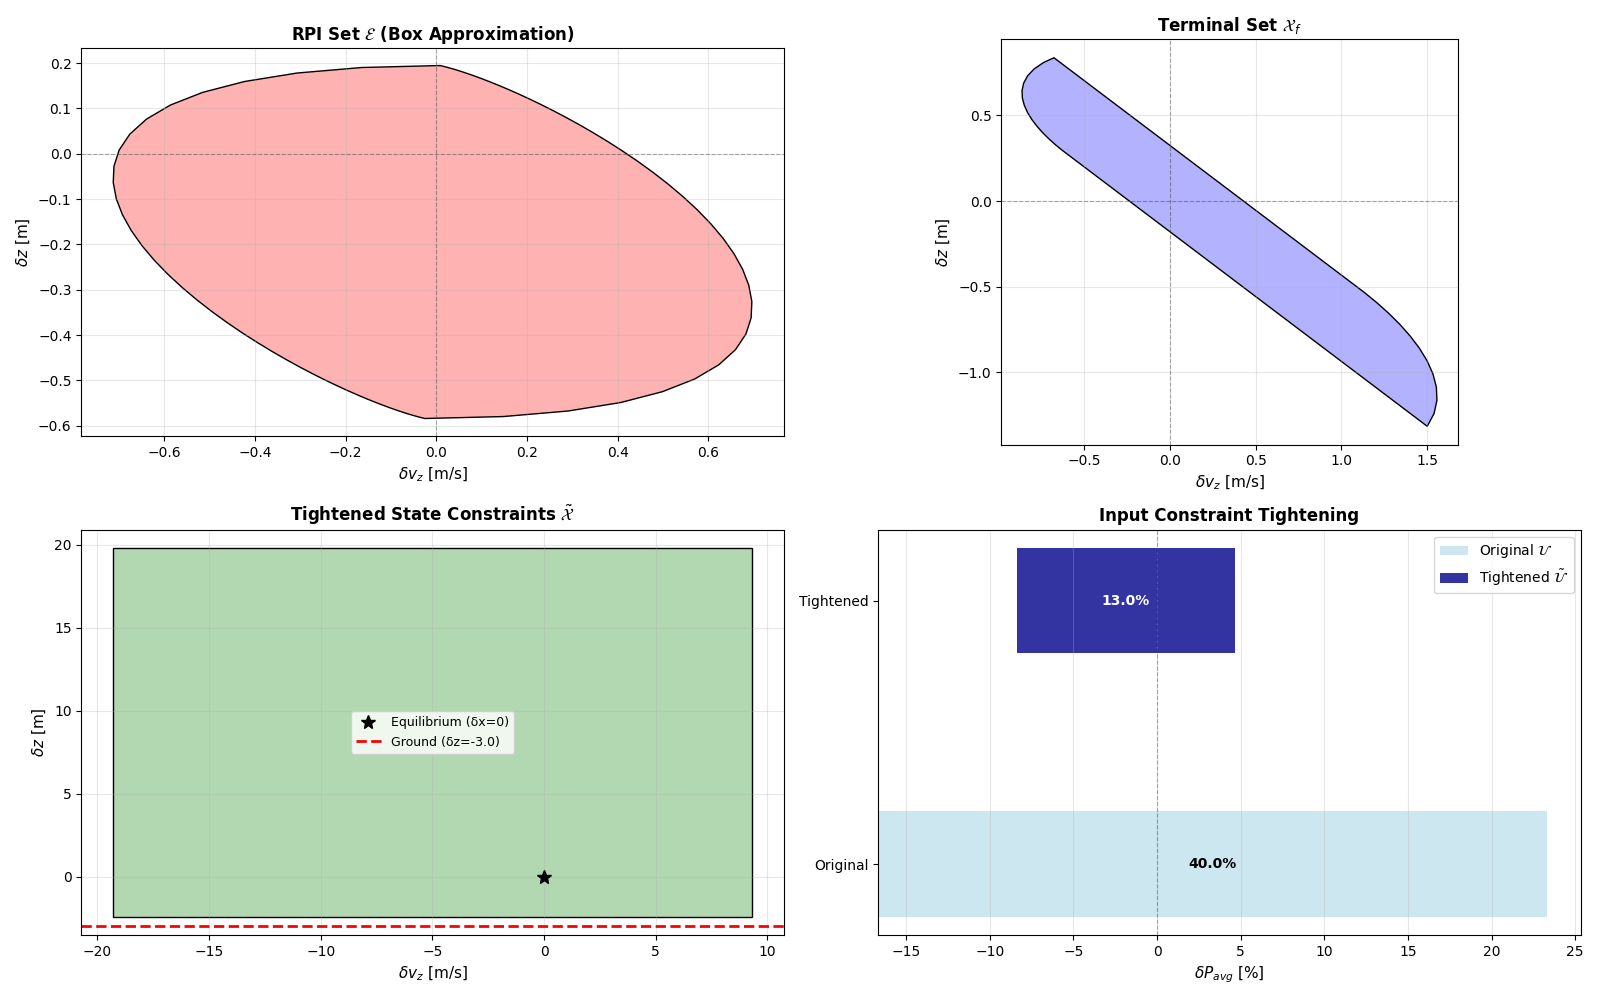

In [35]:
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(2, 2, 1)  
ax2 = plt.subplot(2, 2, 2)  
ax3 = plt.subplot(2, 2, 3)  
ax4 = plt.subplot(2, 2, 4)  

E.plot(ax1, color='red', opacity=0.3)
ax1.axhline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
ax1.axvline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
ax1.set_xlabel(r'$\delta v_z$ [m/s]', fontsize=11)
ax1.set_ylabel(r'$\delta z$ [m]', fontsize=11)
ax1.set_title('RPI Set $\\mathcal{E}$ (Box Approximation)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal', adjustable='box')

Xf.plot(ax2, color='blue', opacity=0.3)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
ax2.axvline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
ax2.set_xlabel(r'$\delta v_z$ [m/s]', fontsize=11)
ax2.set_ylabel(r'$\delta z$ [m]', fontsize=11)
ax2.set_title('Terminal Set $\\mathcal{X}_f$', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal', adjustable='box')

X_tilde.plot(ax3, color='green', opacity=0.3)
ax3.plot(0, 0, 'k*', markersize=10, label='Equilibrium (δx=0)')
z_ground = -xs[11] 
ax3.axhline(z_ground, color='r', linestyle='--', linewidth=2, 
            label=f'Ground (δz={z_ground:.1f})')
ax3.set_xlabel(r'$\delta v_z$ [m/s]', fontsize=11)
ax3.set_ylabel(r'$\delta z$ [m]', fontsize=11)
ax3.set_title('Tightened State Constraints $\\tilde{\\mathcal{X}}$', 
                fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=9, loc='best')

# Original vs Tightened
u_orig_min = 40.0 - us[2]
u_orig_max = 80.0 - us[2]

ax4.barh([1], [u_orig_max - u_orig_min], left=[u_orig_min], 
        height=0.4, color='lightblue', alpha=0.6, label='Original $\\mathcal{U}$')
ax4.barh([2], [mpc.u_tilde_max - mpc.u_tilde_min], left=[mpc.u_tilde_min], 
        height=0.4, color='darkblue', alpha=0.8, label='Tightened $\\tilde{\\mathcal{U}}$')

ax4.axvline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
ax4.set_xlabel(r'$\delta P_{avg}$ [%]', fontsize=11)
ax4.set_yticks([1, 2])
ax4.set_yticklabels(['Original', 'Tightened'])
ax4.set_title('Input Constraint Tightening', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.legend(fontsize=10)

ax4.text(u_orig_min + (u_orig_max - u_orig_min)/2, 1, 
        f'{u_orig_max - u_orig_min:.1f}%', 
        ha='center', va='center', fontsize=10, fontweight='bold')
ax4.text(mpc.u_tilde_min + (mpc.u_tilde_max - mpc.u_tilde_min)/2, 2, 
        f'{mpc.u_tilde_max - mpc.u_tilde_min:.1f}%', 
        ha='center', va='center', fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

## 5. Closed-Loop Simulation: No Noise

Baseline performance without disturbances.

In [36]:
print("SIMULATING WITH NO DISTURBANCES")

try:
    t_cl_none, x_cl_none, u_cl_none = rocket.simulate_subsystem(
        mpc, sim_time, x0, w_type='no_noise'
    )
    
    print("Simulation completed successfully!")
    print(f"\nResults:")
    print(f"  Final altitude: z={x_cl_none[11, -1]:.3f}m (target: {xs[11]:.2f}m)")
    print(f"  Final velocity: vz={x_cl_none[8, -1]:.3f}m/s (target: {xs[8]:.2f}m/s)")
    print(f"  Minimum altitude: z_min={np.min(x_cl_none[11, :]):.3f}m (must be >=0)")
    print(f"  Tracking error: delta z={abs(x_cl_none[11, -1] - xs[11]):.3f}m")
        
    z_error = np.abs(x_cl_none[11, :] - xs[11])
    settled_idx = np.where(z_error < 0.05 * xs[11])[0]
    if len(settled_idx) > 0:
        settle_time = t_cl_none[settled_idx[0]]
        print(f"  Settling time (5%): {settle_time:.2f}s")
    
except Exception as e:
    print(f"Simulation failed: {e}")
    import traceback
    traceback.print_exc()

SIMULATING WITH NO DISTURBANCES
Simulation completed successfully!

Results:
  Final altitude: z=3.000m (target: 3.00m)
  Final velocity: vz=0.000m/s (target: 0.00m/s)
  Minimum altitude: z_min=2.969m (must be >=0)
  Tracking error: delta z=0.000m
  Settling time (5%): 3.70s


## 6. Closed-Loop Simulation: Random Disturbances

Test controller performance under random disturbances w ~ Uniform(W).

In [37]:
print("SIMULATING WITH RANDOM DISTURBANCES")

try:
    t_cl_rand, x_cl_rand, u_cl_rand = rocket.simulate_subsystem(
        mpc, sim_time, x0, w_type='random'
    )
    
    print("Simulation completed successfully")
    print(f"\nResults:")
    print(f"  Final altitude: z={x_cl_rand[11, -1]:.3f}m (target: {xs[11]:.2f}m)")
    print(f"  Final velocity: vz={x_cl_rand[8, -1]:.3f}m/s (target: {xs[8]:.2f}m/s)")
    print(f"  Minimum altitude: z_min={np.min(x_cl_rand[11, :]):.3f}m (must be >=0)")
    print(f"  Tracking error: delta z={abs(x_cl_rand[11, -1] - xs[11]):.3f}m")
    
    z_error = np.abs(x_cl_rand[11, :] - xs[11])
    settled_idx = np.where(z_error < 0.05 * xs[11])[0]
    if len(settled_idx) > 0:
        settle_time = t_cl_rand[settled_idx[0]]
        print(f"  Settling time (5%): {settle_time:.2f}s")
    
except Exception as e:
    print(f"Simulation failed: {e}")
    import traceback
    traceback.print_exc()

SIMULATING WITH RANDOM DISTURBANCES
Simulation completed successfully

Results:
  Final altitude: z=2.720m (target: 3.00m)
  Final velocity: vz=-0.015m/s (target: 0.00m/s)
  Minimum altitude: z_min=2.720m (must be >=0)
  Tracking error: delta z=0.280m
  Settling time (5%): 3.20s


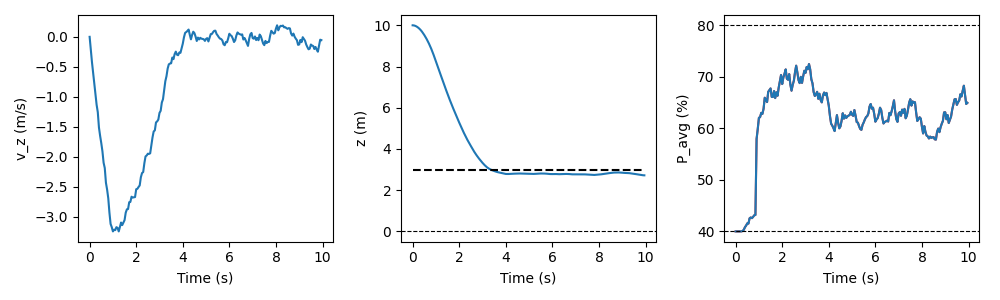

In [38]:
# Visualize trajectories
if 'x_cl_rand' in locals():
    plot_static_states_inputs(t_cl_rand[:-1], x_cl_rand[:,:-1], u_cl_rand, xs, 'sys_z')

## 7. Closed-Loop Simulation: Extreme Disturbance

Stress test with constant worst-case disturbance w = -15.

In [39]:
print("SIMULATING WITH EXTREME DISTURBANCE")

try:
    t_cl_ext, x_cl_ext, u_cl_ext = rocket.simulate_subsystem(
        mpc, sim_time, x0, w_type='extreme'
    )
    
    print("Simulation completed successfully")
    print(f"\nResults:")
    print(f"  Final altitude: z={x_cl_ext[11, -1]:.3f}m (target: {xs[11]:.2f}m)")
    print(f"  Final velocity: vz={x_cl_ext[8, -1]:.3f}m/s (target: {xs[8]:.2f}m/s)")
    print(f"  Minimum altitude: z_min={np.min(x_cl_ext[11, :]):.3f}m (must be >=0)")
    print(f"  Tracking error: delta z={abs(x_cl_ext[11, -1] - xs[11]):.3f}m")
    
    u_ext_pavg = u_cl_ext[2, :]
    saturated = np.sum((u_ext_pavg >= 79.9) | (u_ext_pavg <= 40.1))
    print(f"  Input saturation: {saturated}/{len(u_ext_pavg)} steps ({saturated/len(u_ext_pavg)*100:.1f}%)")
    
except Exception as e:
    print(f"Simulation failed: {e}")
    import traceback
    traceback.print_exc()

SIMULATING WITH EXTREME DISTURBANCE
Simulation completed successfully

Results:
  Final altitude: z=2.420m (target: 3.00m)
  Final velocity: vz=0.000m/s (target: 0.00m/s)
  Minimum altitude: z_min=1.598m (must be >=0)
  Tracking error: delta z=0.580m
  Input saturation: 37/200 steps (18.5%)


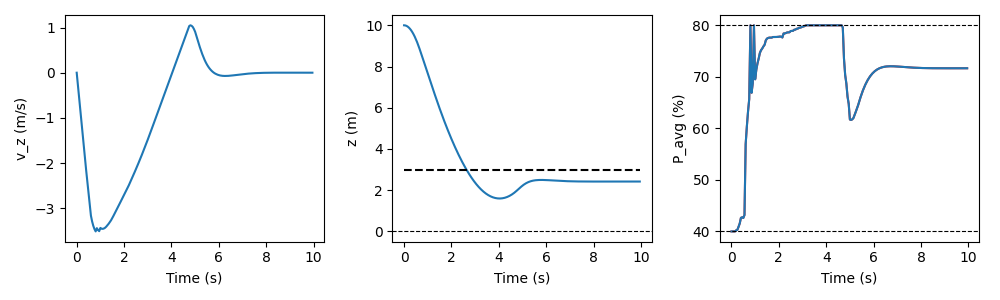

In [40]:
# Visualize trajectories
if 'x_cl_ext' in locals():
    plot_static_states_inputs(t_cl_ext[:-1], x_cl_ext[:,:-1], u_cl_ext, xs, 'sys_z')

## 8. Performance Comparison Plot


Comparison plot saved as 'deliverable_6_1_comparison.png'


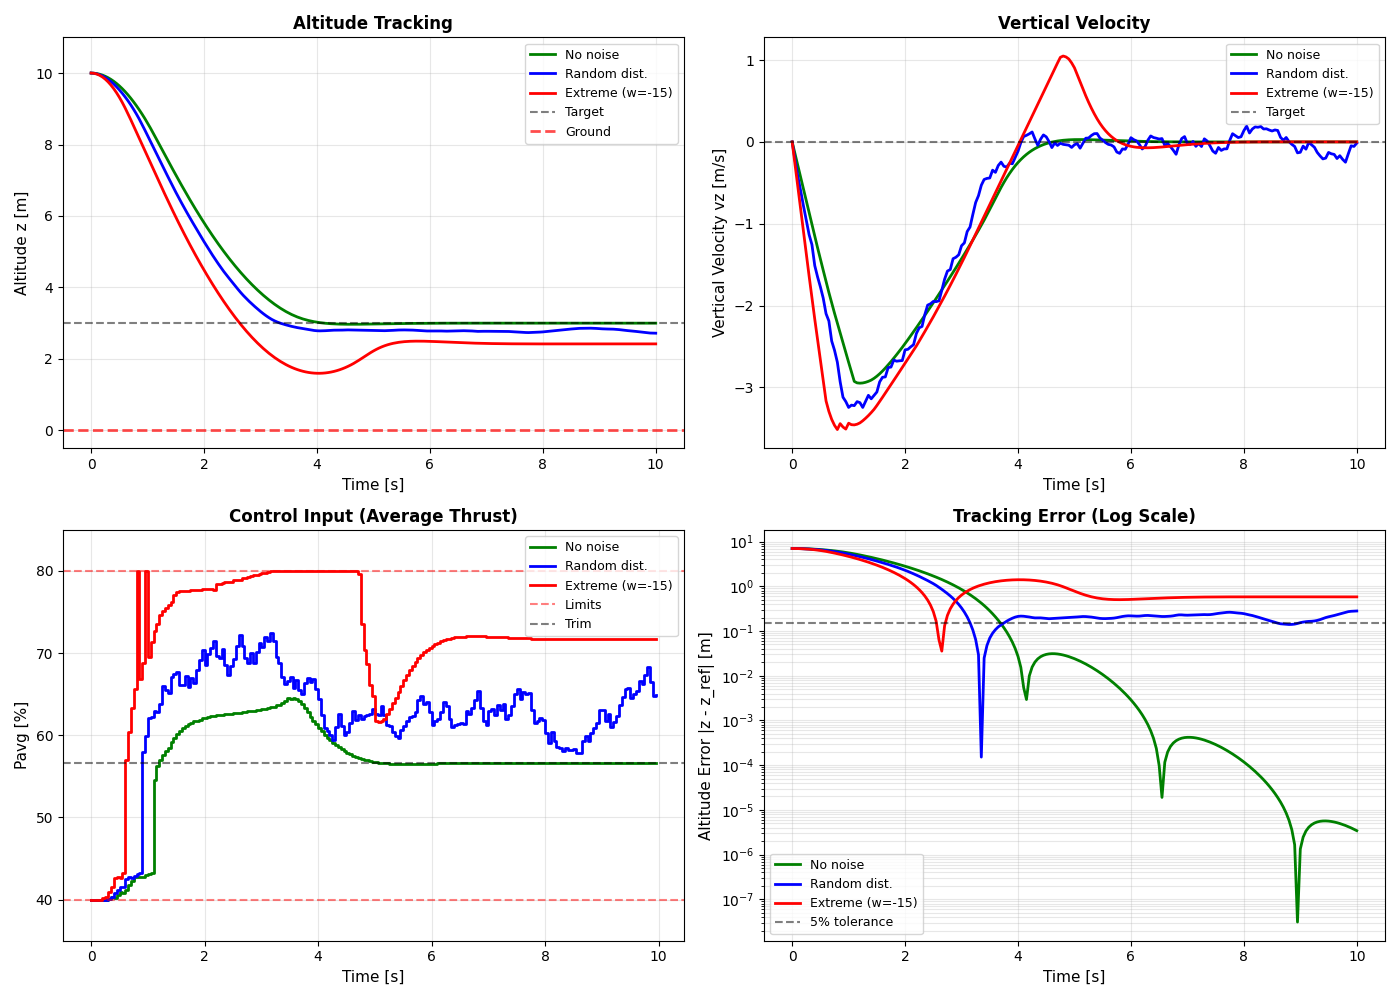

In [41]:


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Altitude
ax = axes[0, 0]
ax.plot(t_cl_none, x_cl_none[11, :], 'g-', linewidth=2, label='No noise')
ax.plot(t_cl_rand, x_cl_rand[11, :], 'b-', linewidth=2, label='Random dist.')
ax.plot(t_cl_ext, x_cl_ext[11, :], 'r-', linewidth=2, label='Extreme (w=-15)')
ax.axhline(xs[11], color='k', linestyle='--', alpha=0.5, label='Target')
ax.axhline(0, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Ground')
ax.set_xlabel('Time [s]', fontsize=11)
ax.set_ylabel('Altitude z [m]', fontsize=11)
ax.set_title('Altitude Tracking', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.set_ylim([-0.5, 11])

# Velocity
ax = axes[0, 1]
ax.plot(t_cl_none, x_cl_none[8, :], 'g-', linewidth=2, label='No noise')
ax.plot(t_cl_rand, x_cl_rand[8, :], 'b-', linewidth=2, label='Random dist.')
ax.plot(t_cl_ext, x_cl_ext[8, :], 'r-', linewidth=2, label='Extreme (w=-15)')
ax.axhline(xs[8], color='k', linestyle='--', alpha=0.5, label='Target')
ax.set_xlabel('Time [s]', fontsize=11)
ax.set_ylabel('Vertical Velocity vz [m/s]', fontsize=11)
ax.set_title('Vertical Velocity', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Input
ax = axes[1, 0]
ax.step(t_cl_none[:-1], u_cl_none[2, :], 'g-', where='post', linewidth=2, label='No noise')
ax.step(t_cl_rand[:-1], u_cl_rand[2, :], 'b-', where='post', linewidth=2, label='Random dist.')
ax.step(t_cl_ext[:-1], u_cl_ext[2, :], 'r-', where='post', linewidth=2, label='Extreme (w=-15)')
ax.axhline(80, color='r', linestyle='--', alpha=0.5, label='Limits')
ax.axhline(40, color='r', linestyle='--', alpha=0.5)
ax.axhline(us[2], color='k', linestyle='--', alpha=0.5, label='Trim')
ax.set_xlabel('Time [s]', fontsize=11)
ax.set_ylabel('Pavg [%]', fontsize=11)
ax.set_title('Control Input (Average Thrust)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.set_ylim([35, 85])

# Tracking error
ax = axes[1, 1]
z_err_none = np.abs(x_cl_none[11, :] - xs[11])
z_err_rand = np.abs(x_cl_rand[11, :] - xs[11])
z_err_ext = np.abs(x_cl_ext[11, :] - xs[11])
ax.semilogy(t_cl_none, z_err_none, 'g-', linewidth=2, label='No noise')
ax.semilogy(t_cl_rand, z_err_rand, 'b-', linewidth=2, label='Random dist.')
ax.semilogy(t_cl_ext, z_err_ext, 'r-', linewidth=2, label='Extreme (w=-15)')
ax.axhline(0.05 * xs[11], color='k', linestyle='--', alpha=0.5, label='5% tolerance')
ax.set_xlabel('Time [s]', fontsize=11)
ax.set_ylabel('Altitude Error |z - z_ref| [m]', fontsize=11)
ax.set_title('Tracking Error (Log Scale)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('deliverable_6_1_comparison.png', dpi=300, bbox_inches='tight')
print("\nComparison plot saved as 'deliverable_6_1_comparison.png'")
plt.show()